In [1]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

# import hdf5storage
# import h5py
import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
# import nelpy.plotting as npl  # optional plotting import

# import math
# import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed
# from scipy.ndimage import gaussian_filter1d
# from sklearn.linear_model import LinearRegression
# import matplotlib
from matplotlib.ticker import AutoMinorLocator
from neurodsp.filt import filter_signal


d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [30]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [3]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat
    
def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = (event.n_events>0)*1
    return unit_mat    

In [47]:
df_ = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')

df = pd.DataFrame()

for basepath in df_.basepath:
    cell_metrics,data = loading.load_cell_metrics(basepath)

    df = df.append(cell_metrics,ignore_index=True)

# number of ca1 pyr units

In [60]:
idx = (df.putativeCellType == "Pyramidal Cell") & (df.bad_unit == False) & ((df.brainRegion == "CA1") | (df.brainRegion == "lCA1") | (df.brainRegion == "rCA1"))
sum(idx)

8530

# Calc participation for each session to get % of cells per ripple

In [6]:
def session_loop(basepath,save_path):
    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.npy')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")) &
                        cell_metrics.bad_unit == False)

    # restrict cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]

    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)

    unit_mat = get_participation(st_unit[ripple_epochs],ripple_epochs)

    np.save(save_file,unit_mat)


save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\participation_mats'
parallel = True 

if parallel:
    num_cores = multiprocessing.cpu_count()         
    processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in df.basepath.unique())
else:    
    for basepath in df.basepath.unique():
        print(basepath)
        session_loop(basepath,save_path) 

# load all data

In [45]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*.npy')
    prop_particip = []
    for session in sessions:
        unit_mat = np.load(session)
        prop_particip.append(np.sum(unit_mat,axis=0) / unit_mat.shape[0])

    return prop_particip
prop_particip = load_in_everything(save_path)    

C:\Users\Cornell\AppData\Local\Temp/ipykernel_29668/3918353024.py:7: RuntimeWarning: invalid value encountered in true_divide


# load just Kenji

In [40]:
def load_in_everything(save_path):
    
    sessions = glob.glob(save_path + os.sep + '*Kenji*' + '*.npy')
    prop_particip = []
    for session in sessions:
        unit_mat = np.load(session)
        prop_particip.append(np.sum(unit_mat,axis=0) / unit_mat.shape[0])

    return prop_particip
prop_particip_kenji = load_in_everything(save_path)   

C:\Users\Cornell\AppData\Local\Temp/ipykernel_29668/3329335997.py:7: RuntimeWarning: invalid value encountered in true_divide


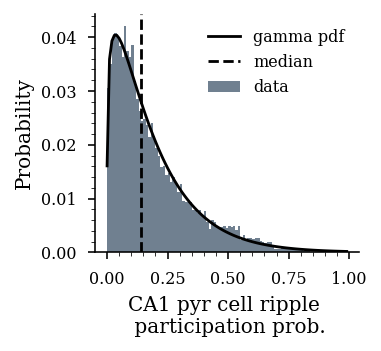

In [53]:
import scipy

def fit_dist(x,y,dist_name='gamma'):
    """
    https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
    """
    # dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto']
    size = len(x)
    dist = getattr(scipy.stats, dist_name)
    params = dist.fit(y)
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    if arg:
        pdf_fitted = dist.pdf(x, *arg, loc=loc, scale=scale) * size
    else:
        pdf_fitted = dist.pdf(x, loc=loc, scale=scale) * size

    return pdf_fitted  

plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1.5, 1)), edgecolor='k')
idx = (df.putativeCellType == "Pyramidal Cell") & ((df.brainRegion == "CA1") | (df.brainRegion == "lCA1") | (df.brainRegion == "rCA1"))
bin_width = 0.01
x = np.arange(0,1,bin_width)
y = df[idx].ripple_particip
bad_idx = np.isnan(y)
y = y[~bad_idx]

values,_ = np.histogram(y,bins=x)
plt.bar(x[:-1]+bin_width/2,values/values.sum(),width=bin_width,color="slategrey",label='data')
gamma_fit = fit_dist(x,y,dist_name='gamma')
plt.plot(x,gamma_fit/gamma_fit.sum(),color="k",label="gamma pdf")

plt.axvline(np.median(y),color='k',ls='--',label='median')

# plt.hist(y,bins=x,color="grey",label='data')
# plt.plot(x,fit_dist(x,y,dist_name='gamma'),color="k",label="gamma pdf")
plt.xlabel('CA1 pyr cell ripple \n participation prob.')
plt.ylabel('Probability')
# plt.ylabel('Counts')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(frameon=False)

plt.savefig(os.path.join(fig_save_path,'all_data_ca1_pyr_participation.svg'),dpi=300,bbox_inches='tight')

 

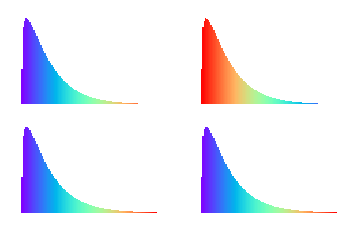

In [32]:
from matplotlib import cm


fig, axs = plt.subplots(2,2, figsize=functions.set_size('thesis', fraction=.5, subplots=(2,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0.2, wspace=0.2)
axs = axs.ravel()

colormap_ = cm.get_cmap('rainbow', len(x))

colors = colormap_(np.linspace(0,1,len(x)))
axs[0].bar(x,gamma_fit/gamma_fit.sum(),width=bin_width,color=colors)
axs[2].bar(x,gamma_fit/gamma_fit.sum(),width=bin_width,color=colors)
axs[3].bar(x,gamma_fit/gamma_fit.sum(),width=bin_width,color=colors)

# colors
axs[1].bar(x,gamma_fit/gamma_fit.sum(),width=bin_width,color=np.flipud(colors))

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')

plt.savefig(os.path.join(fig_save_path,'conceptual_participation_change.pdf'),dpi=300,bbox_inches='tight')


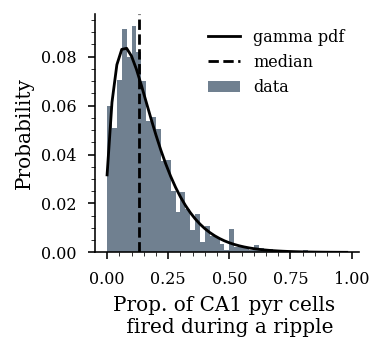

In [33]:
plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1.5, 1)), edgecolor='k')


bin_width = 0.02
x = np.arange(0,1,bin_width)
y = np.hstack(prop_particip)
bad_idx = np.isnan(y)
y = y[~bad_idx]

values,_=np.histogram(y,bins=x)
plt.bar(x[:-1]+bin_width/2,values/values.sum(),width=bin_width,color="slategrey",label='data')
gamma_fit = fit_dist(x,y,dist_name='gamma')
plt.plot(x,gamma_fit/gamma_fit.sum(),color="k",label="gamma pdf")
plt.axvline(np.median(y),color='k',ls='--',label='median')

plt.xlabel('Prop. of CA1 pyr cells \n fired during a ripple')
plt.ylabel('Probability')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(frameon=False)

plt.savefig(os.path.join(fig_save_path,'all_data_ca1_pyr_prop_active_ripples.svg'),dpi=300,bbox_inches='tight')


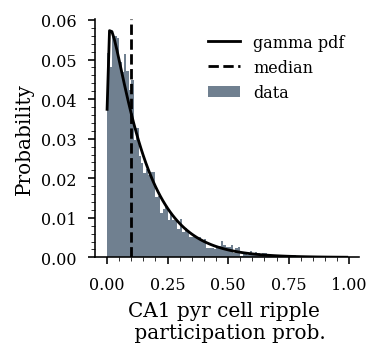

In [44]:
plt.figure(figsize=functions.set_size('thesis', fraction=.4, subplots=(1.5, 1)), edgecolor='k')
idx = (
    (df.putativeCellType == "Pyramidal Cell") &
    ((df.brainRegion == "CA1") | (df.brainRegion == "lCA1") | (df.brainRegion == "rCA1")) & 
    df['basepath'].str.contains("Kenji", case=False)
)
bin_width = 0.01
x = np.arange(0,1,bin_width)
y = df[idx].ripple_particip
bad_idx = np.isnan(y)
y = y[~bad_idx]

values,_ = np.histogram(y,bins=x)
plt.bar(x[:-1]+bin_width/2,values/values.sum(),width=bin_width,color="slategrey",label='data')
gamma_fit = fit_dist(x,y,dist_name='gamma')
plt.plot(x,gamma_fit/gamma_fit.sum(),color="k",label="gamma pdf")

plt.axvline(np.median(y),color='k',ls='--',label='median')

plt.xlabel('CA1 pyr cell ripple \n participation prob.')
plt.ylabel('Probability')
# plt.ylabel('Counts')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(frameon=False)

plt.savefig(os.path.join(fig_save_path,'all_data_ca1_pyr_participation_kenji.svg'),dpi=300,bbox_inches='tight')

# Ripple trace example figure

In [440]:
idx = (df.putativeCellType == "Pyramidal Cell") & ((df.brainRegion == "CA1") | (df.brainRegion == "lCA1") | (df.brainRegion == "rCA1"))

n_units = [sum((df.basepath == basepath) & idx) for basepath in df.basepath.unique()]
np.where(np.array(n_units)>100)

(array([ 97, 214, 224, 226, 228], dtype=int64),)

In [456]:
# df[idx & (df.ripple_particip > .5)]

basepath = df.basepath.unique()[97]

cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")))

# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
behavioral_epochs = nel.EpochArray([np.array([data['epochs'].startTime,
                                                data['epochs'].stopTime]).T])

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [457]:
filename = glob.glob(os.path.join(basepath,'*.lfp'))[0]
nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)

rip_ch = ripples.ripple_channel.unique()[0]
for sh in shank_to_channel:
    if np.any(shank_to_channel[sh] == rip_ch):
        shank = sh
        break

channel_idx = np.where(shank_to_channel[shank] == rip_ch)[0][0]

lfp,ts = loading.loadLFP(filename, n_channels=nChannels, channel=shank_to_channel[shank], frequency=fs, precision='int16')


In [458]:
lfp_obj = nel.AnalogSignalArray(data=lfp.T,fs=fs)
lfp_obj_zscore = lfp_obj.zscore()
lfp_obj

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


<AnalogSignalArray at 0x1a7b1d1c040: 10 signals> for a total of 9:41:01:103 hours

In [371]:
n_active = [st_unit[rip].n_active for rip in ripple_epochs]

In [426]:
top_idx = np.argsort(n_active)[-30:]
top_idx

array([ 9571,  1761,  4944,  1128,  5545,  1868,  8219,  1652, 11255,
        3563,  7935,  3398,  3057,  1115,  5383,  4516,  7398,  7399,
        6822,  3878,  6832,  1660,  3566,  7339,  6302, 10438,  2543,
        2285,  8069,  3565], dtype=int64)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


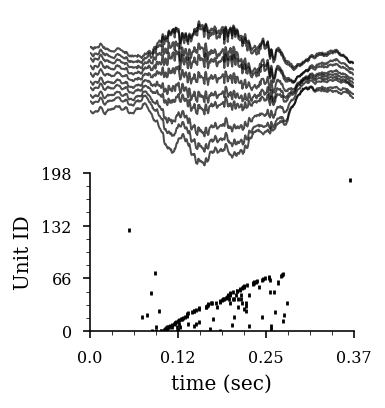

In [439]:
fig, axs = plt.subplots(2,1, figsize=functions.set_size('thesis', fraction=.4, subplots=(2,1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.2)
axs = axs.ravel()

# rip_n = int(np.argmax(n_active))
rip_n = 2543
rip_n = 10438 # interesting double ripple
rip_n = 8069

plotting_epoch = nel.EpochArray([np.array([ripple_epochs[rip_n].start-.1,ripple_epochs[rip_n].stop+.1]).T])

offset = (np.arange(lfp_obj.data.shape[0],0,-1)*500)
axs[0].plot(lfp_obj[plotting_epoch]._abscissa_vals,lfp_obj[plotting_epoch].data.T+offset,color='k',linewidth=1,alpha=.7)

# axs[0].plot(lfp_obj[plotting_epoch]._abscissa_vals,lfp_obj[plotting_epoch].data.T,color='k',alpha=.75)

idx = np.array(st_unit[ripple_epochs[plotting_epoch]].get_event_firing_order())-1

axs[1].eventplot(st_unit[plotting_epoch].data[idx],color='k',linelengths=5)

axs[0].set_xlim(plotting_epoch.start,plotting_epoch.stop)   
axs[1].set_xlim(plotting_epoch.start,plotting_epoch.stop)   

x = np.linspace(plotting_epoch.start,plotting_epoch.stop,4)
axs[1].set_xticks(x)
axs[1].set_xticklabels(np.round(x-plotting_epoch.start,2))

for i in range(2):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs[0].axes.xaxis.set_visible(False)
axs[0].axes.yaxis.set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["left"].set_visible(False) 

axs[1].set_yticks(np.linspace(0,cell_metrics.UID.unique().shape[0],4))
axs[1].set_ylim(0,cell_metrics.UID.unique().shape[0])
axs[1].set_xlabel('time (sec)')
axs[1].set_ylabel('Unit ID')

plt.savefig(os.path.join(fig_save_path,'single_lfp_traces_raster_example.pdf'),dpi=300,bbox_inches='tight')


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


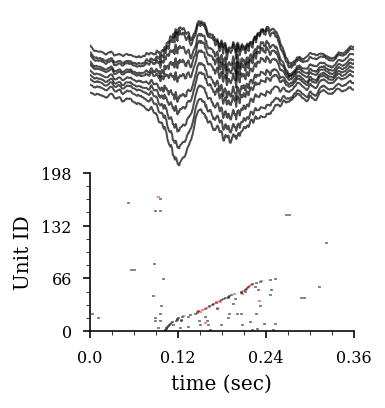

In [471]:
fig, axs = plt.subplots(2,1, figsize=functions.set_size('thesis', fraction=.4, subplots=(2,1)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.2)
axs = axs.ravel()

colors1 = np.array(['k']*cell_metrics.shape[0])
colors1[cell_metrics.deepSuperficial == "Superficial"] = 'r'

# rip_n = int(np.argmax(n_active))
rip_n = 2543
rip_n = 10438 # interesting double ripple

plotting_epoch = nel.EpochArray([np.array([ripple_epochs[rip_n].start-.1,ripple_epochs[rip_n].stop+.1]).T])

offset = (np.arange(lfp_obj.data.shape[0],0,-1)*500)
axs[0].plot(lfp_obj[plotting_epoch]._abscissa_vals,lfp_obj[plotting_epoch].data.T+offset,color='k',linewidth=1,alpha=.7)

idx = np.array(st_unit[ripple_epochs[plotting_epoch]].get_event_firing_order())-1

axs[1].eventplot(st_unit[plotting_epoch].data[idx],color=colors1)

axs[0].set_xlim(plotting_epoch.start,plotting_epoch.stop)   
axs[1].set_xlim(plotting_epoch.start,plotting_epoch.stop)   

x = np.linspace(plotting_epoch.start,plotting_epoch.stop,4)
axs[1].set_xticks(x)
axs[1].set_xticklabels(np.round(x-plotting_epoch.start,2))

for i in range(2):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs[0].axes.xaxis.set_visible(False)
axs[0].axes.yaxis.set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["left"].set_visible(False) 

axs[1].set_yticks(np.linspace(0,cell_metrics.UID.unique().shape[0],4))
axs[1].set_ylim(0,cell_metrics.UID.unique().shape[0])
axs[1].set_xlabel('time (sec)')
axs[1].set_ylabel('Unit ID')

plt.savefig(os.path.join(fig_save_path,'single_lfp_traces_raster_example_deep_sup.pdf'),dpi=300,bbox_inches='tight')
plt.savefig(os.path.join(fig_save_path,'single_lfp_traces_raster_example_deep_sup.png'),dpi=300,bbox_inches='tight')


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


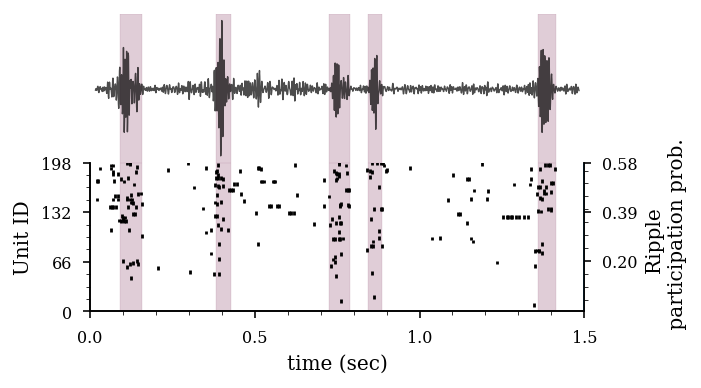

In [362]:
fig, axs = plt.subplots(2,1, figsize=functions.set_size('thesis', fraction=.75, subplots=(1.5,1.5)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.2)
axs = axs.ravel()

plotting_epoch = nel.EpochArray([np.array([3951.4,3952.9]).T])

# Define a frequency range to filter the data
f_range = (100, 250)
# Bandpass filter the data, across the band of interest
sig_filt = filter_signal(lfp_obj[plotting_epoch].data[channel_idx], fs, 'bandpass', f_range)
# plot bandpass filtered
axs[0].plot(lfp_obj[plotting_epoch]._abscissa_vals,sig_filt,color='k',alpha=.7,linewidth=.7,label='ripple bandpass filtered')

# sort by ripple participation
idx = np.argsort(cell_metrics.ripple_particip)
axs[1].eventplot(st_unit[plotting_epoch].data[idx],color='k',linelengths=5)

for rip in ripple_epochs[plotting_epoch]:
    axs[0].axvspan(rip.start,rip.stop,color='#843b62',alpha=.25,zorder=-1000)
    axs[1].axvspan(rip.start,rip.stop,color='#843b62',alpha=.25,zorder=-1000)

axs[0].set_xlim(plotting_epoch.start,plotting_epoch.stop)   
axs[1].set_xlim(plotting_epoch.start,plotting_epoch.stop)   

x = np.linspace(plotting_epoch.start,plotting_epoch.stop,4)
axs[1].set_xticks(x)
axs[1].set_xticklabels(np.round(x-plotting_epoch.start,2))

axs[1].set_yticks(np.linspace(0,cell_metrics.UID.unique().shape[0],4))
axs[1].set_ylim(0,cell_metrics.UID.unique().shape[0])
axs[1].set_xlabel('time (sec)')
axs[1].set_ylabel('Unit ID')

# secondary axis
ax2 = axs[1].twinx()
ax2.plot([plotting_epoch.stop,plotting_epoch.stop],[cell_metrics.ripple_particip.min(),cell_metrics.ripple_particip.max()])
ax2.set_yticks(np.round(np.linspace(cell_metrics.ripple_particip.min(),cell_metrics.ripple_particip.max(),4),2))
ax2.set_ylim(cell_metrics.ripple_particip.min(),cell_metrics.ripple_particip.max())
ax2.set_ylabel('Ripple \n participation prob.')
ax2.spines["top"].set_visible(False)
ax2.yaxis.set_minor_locator(AutoMinorLocator())

for i in range(2):
    axs[i].spines["top"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].yaxis.set_minor_locator(AutoMinorLocator())

axs[0].axes.xaxis.set_visible(False)
axs[0].axes.yaxis.set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["left"].set_visible(False)    


plt.savefig(os.path.join(fig_save_path,'lfp_traces_raster_example.pdf'),dpi=300,bbox_inches='tight')

# testing out figures below

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


Text(0, 0.5, 'Unit ID')

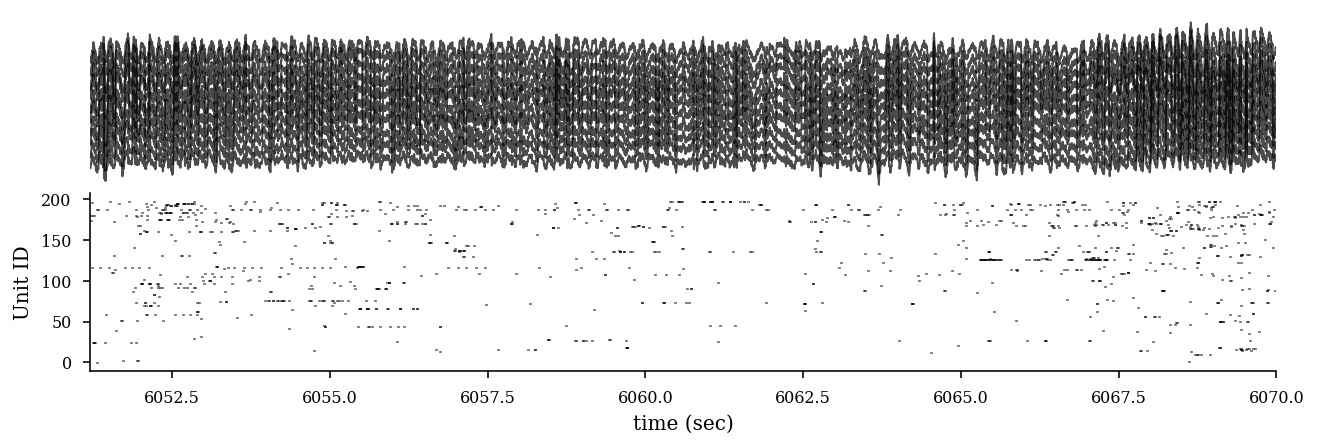

In [267]:
fig, axs = plt.subplots(2,1, figsize=functions.set_size('thesis', fraction=1.8, subplots=(1,2)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.2)
axs = axs.ravel()

plotting_epoch = nel.EpochArray([np.array([6051.2,6070]).T])

offset = (np.arange(lfp_obj_zscore.data.shape[0],0,-1)*1.5)+st_unit.n_active
axs[0].plot(lfp_obj_zscore[plotting_epoch]._abscissa_vals,lfp_obj_zscore[plotting_epoch].data.T+offset,color='k',linewidth=1,alpha=.7)

idx = np.argsort(cell_metrics.ripple_particip)
# idx = st_unit[ripple_epochs[plotting_epoch][0]].get_event_firing_order()
# idx = np.array(st_unit[ripple_epochs[plotting_epoch]].get_event_firing_order())-1

axs[1].eventplot(st_unit[plotting_epoch].data[idx],color='k')

for rip in ripple_epochs[plotting_epoch]:
    axs[0].axvspan(rip.start,rip.stop,color='#843b62',alpha=.25,zorder=-1000)
    axs[1].axvspan(rip.start,rip.stop,color='#843b62',alpha=.25,zorder=-1000)

axs[0].set_xlim(plotting_epoch.start,plotting_epoch.stop)   
axs[1].set_xlim(plotting_epoch.start,plotting_epoch.stop)   

for i in range(2):
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)

axs[0].axes.xaxis.set_visible(False)
axs[0].axes.yaxis.set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["left"].set_visible(False)    

axs[1].set_xlabel('time (sec)')
axs[1].set_ylabel('Unit ID')
# plt.savefig(os.path.join(fig_save_path,'lfp_traces_raster_example_v2.pdf'),dpi=300,bbox_inches='tight')


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


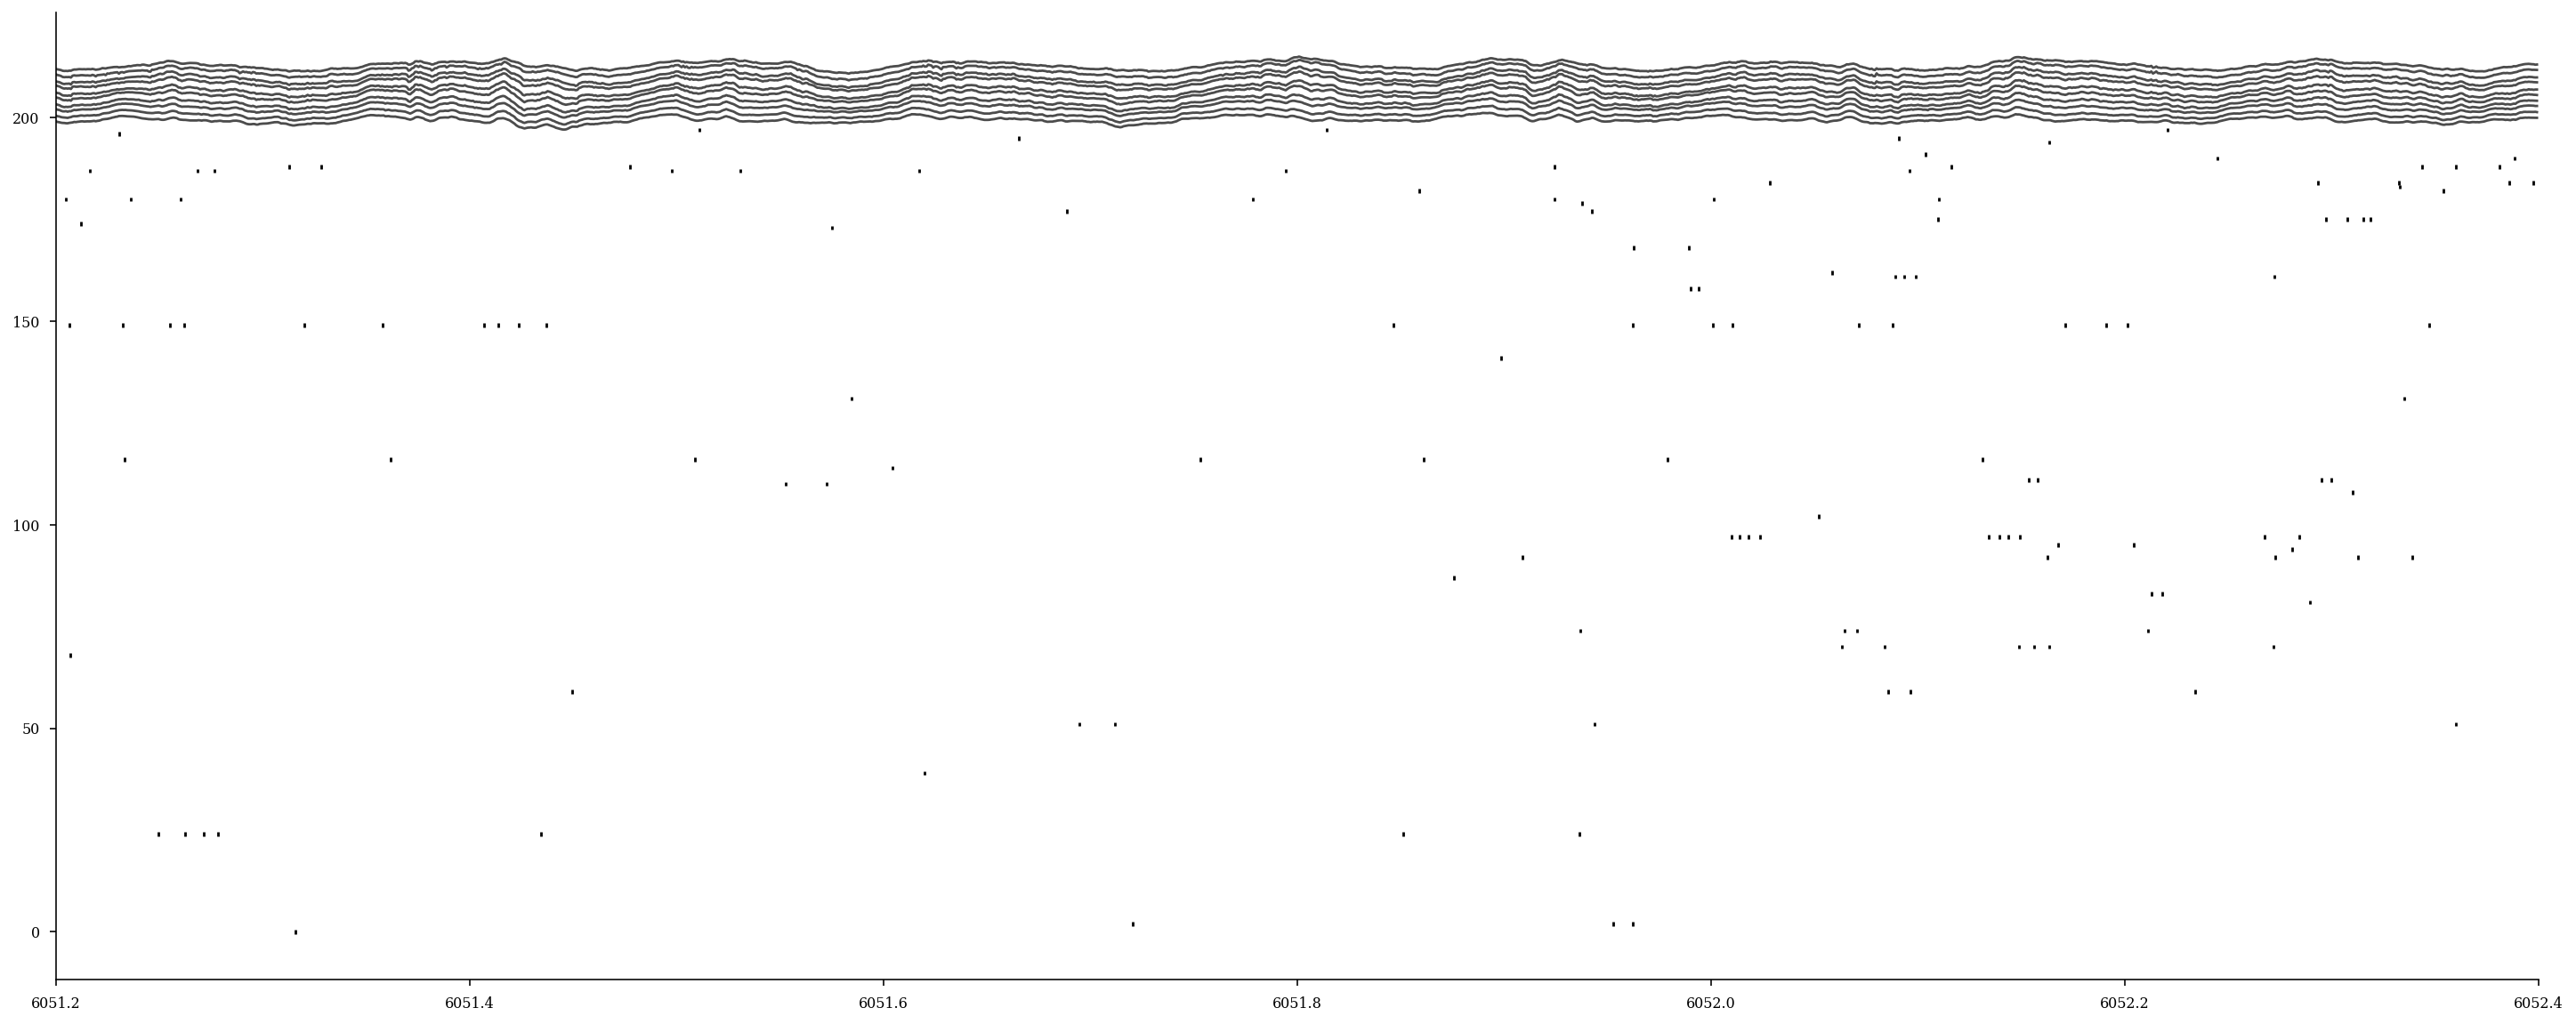

In [268]:
plotting_epoch = nel.EpochArray([np.array([6051.2,6052.4]).T])

idx = np.argsort(cell_metrics.ripple_particip)
plt.figure(figsize=(25,10))
offset = (np.arange(lfp_obj_zscore.data.shape[0],0,-1)*1.5)+st_unit.n_active
plt.plot(lfp_obj_zscore[plotting_epoch]._abscissa_vals,lfp_obj_zscore[plotting_epoch].data.T+offset,color='k',alpha=.7)

plt.eventplot(st_unit[plotting_epoch].data[idx],color='k')

for rip in ripple_epochs[plotting_epoch]:
    plt.axvspan(rip.start,rip.stop,color='r',alpha=.25,zorder=-1000)
plt.xlim(plotting_epoch.start,plotting_epoch.stop)    
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

In [129]:
ripple_epochs.starts
ripple_epochs[2].starts

array([206.6392])

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


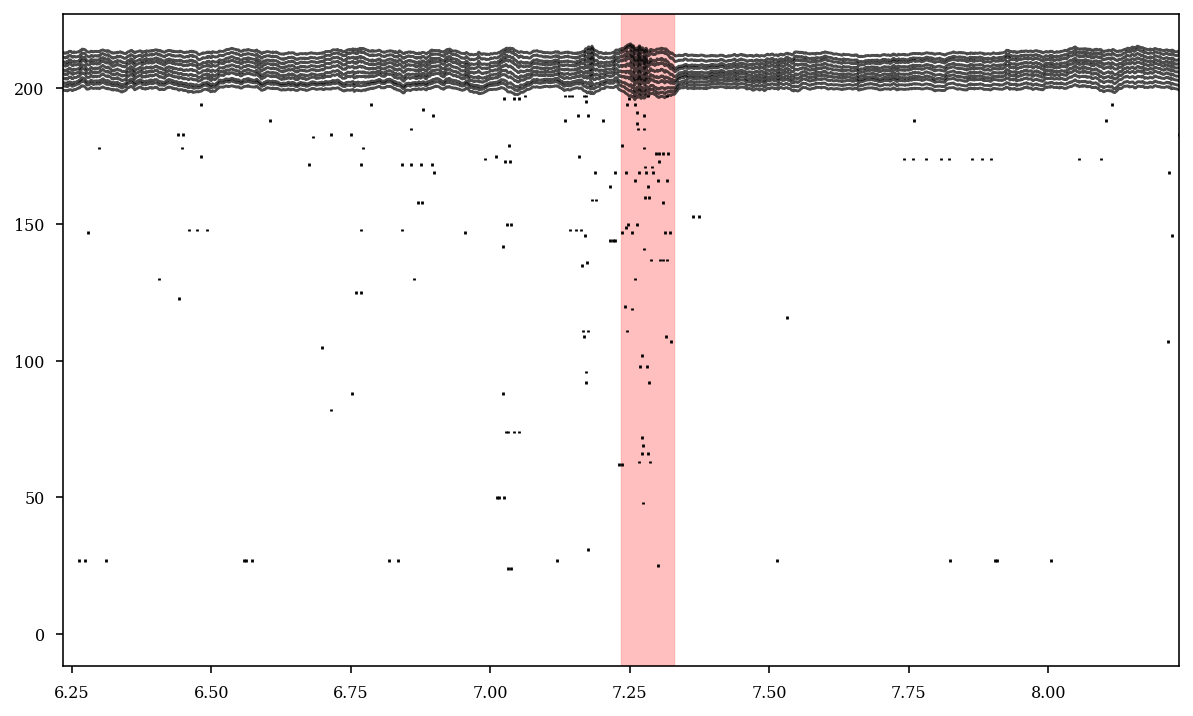

In [271]:
rip_n = 0

plotting_epoch = nel.EpochArray([np.array([ripple_epochs[rip_n].starts-1,ripple_epochs[rip_n].starts+1]).T])

idx = np.argsort(cell_metrics.ripple_particip)
plt.figure(figsize=(10,6))

offset = (np.arange(lfp_obj_zscore.data.shape[0],0,-1)*1.5)+st_unit.n_active
plt.plot(lfp_obj_zscore[plotting_epoch]._abscissa_vals,lfp_obj_zscore[plotting_epoch].data.T+offset,color='k',alpha=.7)

plt.eventplot(st_unit[plotting_epoch].data[idx],color='k')

for rip in ripple_epochs[plotting_epoch]:
    plt.axvspan(rip.start,rip.stop,color='r',alpha=.25,zorder=-1000)
plt.xlim(plotting_epoch.start,plotting_epoch.stop)    
plt.show()